In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_data = pd.read_csv('./Data/train_df.csv')
meal_info = pd.read_csv('./Data/meal_info.csv')
fulfilment_center_info = pd.read_csv('./Data/fulfilment_center_info.csv')

**Описание данных таблицы train_df:**  

**id** - уникальный id  
**week** - номер недели  
**center_id** - уникальный id для центра  
**meal_id** - уникальный id для блюда  
**chekout_price** - фактическая цена продажи  
**base_price** - базовая цена  
**emailer_for_promotion** - была ли рассылка с рекламой блюда  
**homepage_feature** - размещалось ли блюдо на главной странице сайта  
**num_orders** - количество заказов (Целевая переменная)

**Описание данных таблицы meal_info:**

**meal_id** - уникальный id для блюда  
**category** - тип блюда (напиток/суп/снэки/...)  
**cuisine** - кухня блюда (Италия/Мексика/...)  

**Описание данных таблицы fulfilment_center_info:**  

**center_id** - уникальный id для центра  
**city_code** - уникальный код города  
**region_code** - уникальный код региона  
**center_type** - тип центра  
**op_area** - площадь обслуживания центра



In [3]:
train_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [4]:
train_data.shape

(407243, 9)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407243 entries, 0 to 407242
Data columns (total 9 columns):
id                       407243 non-null int64
week                     407243 non-null int64
center_id                407243 non-null int64
meal_id                  407243 non-null int64
checkout_price           407243 non-null float64
base_price               407243 non-null float64
emailer_for_promotion    407243 non-null int64
homepage_featured        407243 non-null int64
num_orders               407243 non-null int64
dtypes: float64(2), int64(7)
memory usage: 28.0 MB


Пропусков в данных нет.

In [6]:
train_data.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.072430e+05,407243.000000,407243.000000,407243.000000,407243.000000,407243.000000,407243.000000,407243.000000,407243.000000
mean,1.249982e+06,67.114241,82.120115,2023.651554,331.265163,353.251941,0.082528,0.110200,264.387889
std,1.443946e+05,37.259672,45.977340,547.367071,153.289316,160.697550,0.275168,0.313139,401.031825
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.000000,13.000000
25%,1.124816e+06,35.000000,43.000000,1558.000000,228.010000,243.500000,0.000000,0.000000,54.000000
50%,1.249941e+06,68.000000,76.000000,1971.000000,292.030000,309.430000,0.000000,0.000000,136.000000
75%,1.375048e+06,99.000000,110.000000,2539.000000,443.350000,459.810000,0.000000,0.000000,324.000000
max,1.499999e+06,130.000000,186.000000,2956.000000,767.330000,767.330000,1.000000,1.000000,24299.000000


In [7]:
#список недель в train_df
print('Количество недель в тренировочном датасете:' ,train_data['week'].nunique())

Количество недель в тренировочном датасете: 130


In [8]:
print('Сколько уникальных значений в колонках *_id?\n')
for c in ['center_id', 'meal_id']:
    print(f'{c}: {train_data[c].nunique()}')

Сколько уникальных значений в колонках *_id?

center_id: 77
meal_id: 51


У нас есть более 400 тысяч записей за 130 недель в тренировочном датасете.  
77 уникальных центров и 51 вид блюда.  

Компания занимается доставкой блюд и имеет много центров, c которых и делается доставка клиентам.

Нужно построить модель, которая предсказывает количество заказов за неделю для пары (центр;блюдо) в следующие 15 недель с учётом планов по ценовым акциям и промо. 

## Блюда

Сколько блюд в среднем продают в неделю?

In [9]:
meal_per_week = train_data.groupby(['week']).agg({'num_orders':'sum'})

In [10]:
meal_per_week.mean()

num_orders    828231.669231
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015FAAF524E0>]],
      dtype=object)

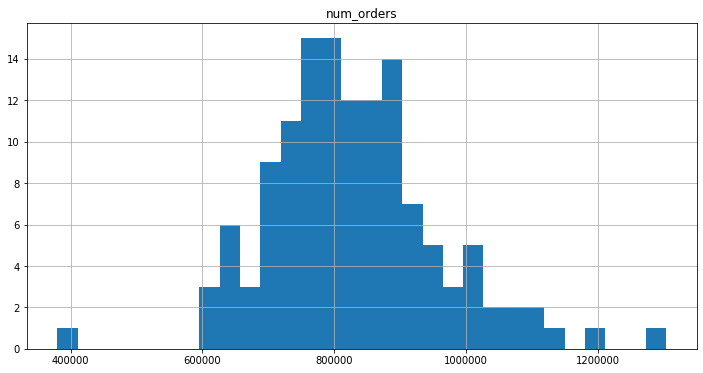

In [11]:
meal_per_week.hist(bins=30, figsize=(12,6))

Из графика видно, что в основном в среднем продают от 600 000 до 1 000 000 блюд в неделю, но есть небольшие выбросы.

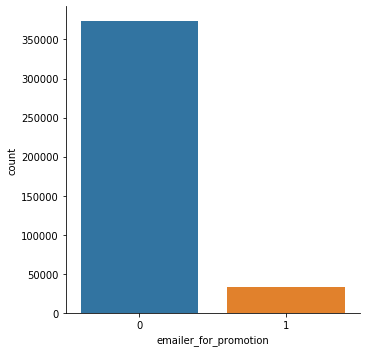

In [12]:
#продажи блюда с акцией и без
sns.catplot(x='emailer_for_promotion',data=train_data,kind='count',height=5,aspect=1)

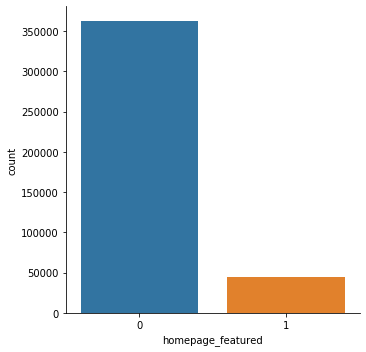

In [13]:
#продажи блюда с размещением на главной странице сайта и без
sns.catplot(x='homepage_featured',data=train_data,kind='count',height=5,aspect=1)

Два графика выше показывают, что значительно больше продаются блюд без акции и размещения на главной странице сайта. Хотя это не говорит о том, что реклама не работает. Нужно смотреть в разрезе конкретных блюд, на которые распространялась акция.

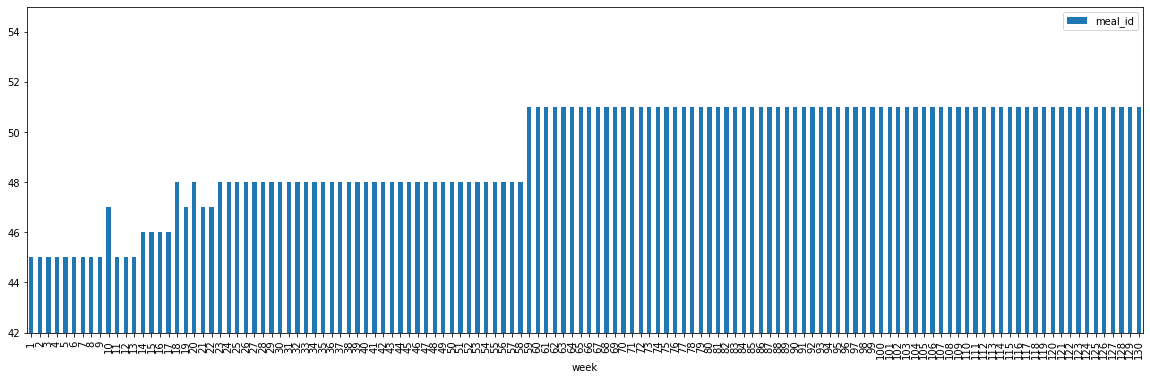

In [14]:
#посмотрим на количество продаж уникальных наименований блюд
train_data.groupby(['week']).agg({'meal_id':'nunique'}).plot(kind='bar', figsize=(20,6), ylim=(42,55))

Из графика видно расширение ассортимента блюд.  
На первой неделе было 45 блюд, на 14ой неделе прибавилось одно новое блюдо, к 60й неделе ассортимент расширился до 51 блюда.

In [15]:
print ('Пересечение уникальных названий блюд на 1 и на 130 неделе:', len(np.intersect1d(train_data.loc[train_data['week'] == 1, 'meal_id'].unique(), 
               train_data.loc[train_data['week'] == 130, 'meal_id'].unique())))

Пересечение уникальных названий блюд на 1 и на 130 неделе: 45


Из этого можно сделать вывод, что блюда из ассортимента не удаляли, а происходило только добавление новых.  

Посмотрим на графики продаж некоторых отдельных блюд и общий график продаж за весь период:

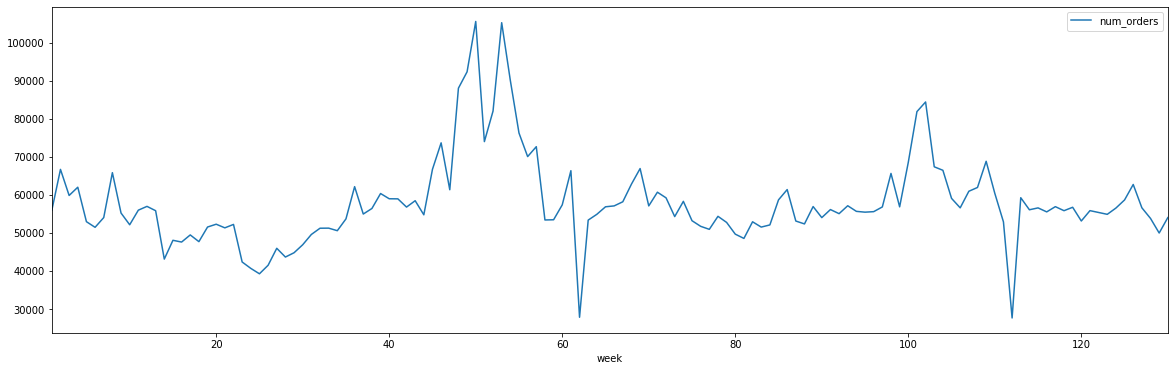

In [16]:
#график продаж блюда с meal_id=1885 за весь период
train_data.loc[train_data['meal_id']==1885, ['num_orders', 'week']].groupby('week').agg('sum').plot(figsize=(20,6))

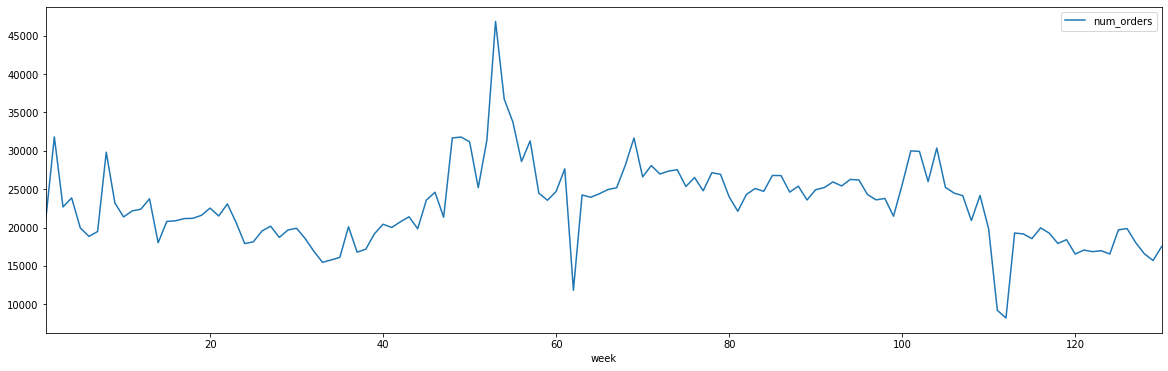

In [17]:
#график продаж блюда с meal_id=2539 за весь период
train_data.loc[train_data['meal_id']==2539, ['num_orders', 'week']].groupby('week').agg('sum').plot(figsize=(20,6))

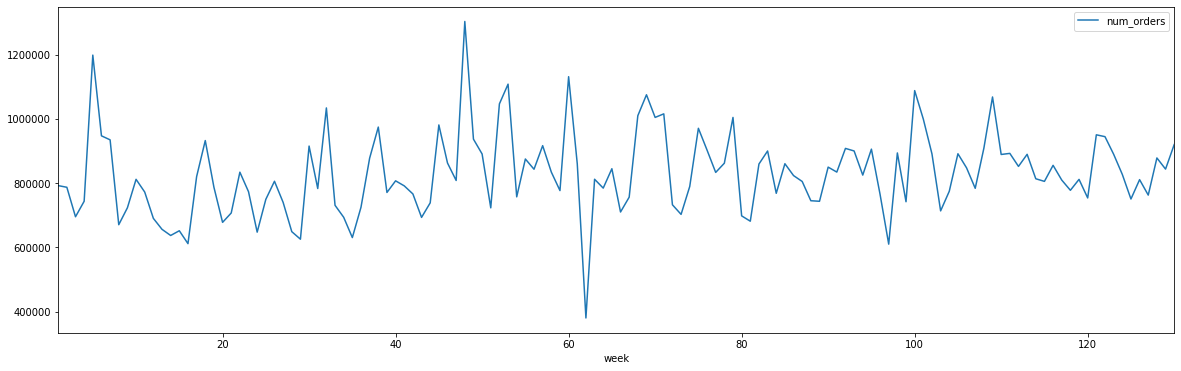

In [18]:
#график общих продаж блюд за весь период
train_data.loc[:, ['num_orders', 'week']].groupby('week').agg('sum').plot(figsize=(20,6))

Три графика выше показывают проседание продаж блюд на примерно 61-62 неделе (начало сл.календарного года).  
На двух графиках продаж отдельных блюд также видно проседание продаж на 110 неделе (что также совпадает с началом сл.календарного года).  
Возможно, это связано с какими-то праздниками (либо начало праздников, либо их конец).

In [19]:
train_data_meal = pd.merge(train_data, meal_info, on='meal_id', how='left')

In [20]:
train_data_meal.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian


In [21]:
#проверим, что число записей в таблице не изменилось
train_data_meal.shape

(407243, 11)

In [22]:
train_data.shape

(407243, 9)

Посмотрим на количество уникальных категорий блюд и видов кухни:

In [23]:
train_data_meal['category'].unique()

array(['Beverages', 'Rice Bowl', 'Starters', 'Pasta', 'Sandwich',
       'Biryani', 'Extras', 'Pizza', 'Seafood', 'Other Snacks', 'Desert',
       'Soup', 'Salad', 'Fish'], dtype=object)

In [24]:
train_data_meal['cuisine'].unique()

array(['Thai', 'Indian', 'Italian', 'Continental'], dtype=object)

Построим графики средних продаж блюд в неделю для каждой категории и для каждой кухни:

In [25]:
category_meal_mean = train_data_meal.groupby(['category']).agg({'num_orders':'sum'})/130
category_meal_mean = category_meal_mean.sort_values(by='num_orders', ascending=False)
category_meal_mean.reset_index(level=0, inplace=True)

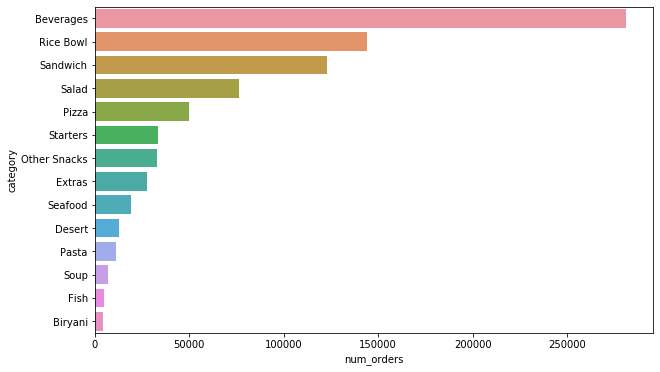

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='num_orders', y='category', data=category_meal_mean, ax=ax)

Три наиболее часто продаваемых категории блюд - это напитки, миска риса и сэндвичи.  
Менее продаваемые суп, рыба и бирьяни. Возможно, эти блюда были позже введены в ассортимент. 

Посмотрим какая кухня самая популярная:

In [27]:
cuisine_meal_mean = train_data_meal.groupby(['cuisine']).agg({'num_orders':'sum'})/130
cuisine_meal_mean = cuisine_meal_mean.sort_values(by='num_orders', ascending=False)
cuisine_meal_mean.reset_index(level=0, inplace=True)

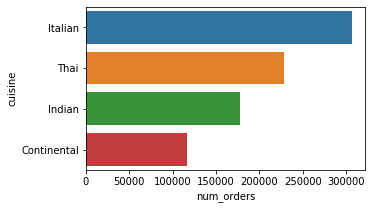

In [28]:
fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(x='num_orders', y='cuisine', data=cuisine_meal_mean, ax=ax)

## Центры продаж

In [29]:
train_data_center = pd.merge(train_data, fulfilment_center_info, on='center_id', how='left')

In [30]:
train_data_center.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0


Посчитаем количество уникальных городов, регионов и типов центров:

In [31]:
print('center_id:', train_data_center['center_id'].nunique())
print('city_code:', train_data_center['city_code'].nunique())
print('region_code:', train_data_center['region_code'].nunique())
print('center_type:', train_data_center['center_type'].nunique())

center_id: 77
city_code: 51
region_code: 8
center_type: 3


In [32]:
train_data.groupby('center_id').agg({'meal_id':'nunique'}).mean()

meal_id    46.662338
dtype: float64

В выборке 77 центров. В них представлены в среднем 46 наименований блюд.  
Посмотрим на статистику продаж в неделю в разбивке центров.

In [33]:
sales_per_center_per_week = train_data.groupby('center_id').agg({'num_orders':'sum'})/130
sales_per_center_per_week = sales_per_center_per_week.sort_values(by='num_orders', ascending=False)
sales_per_center_per_week.describe()

,num_orders
count,77.000000
mean,10756.255445
std,5237.643275
min,2903.253846
25%,7160.100000
50%,9416.430769
75%,12935.246154
max,29582.992308


In [34]:
sales_per_center_per_week.reset_index(level=0, inplace=True)

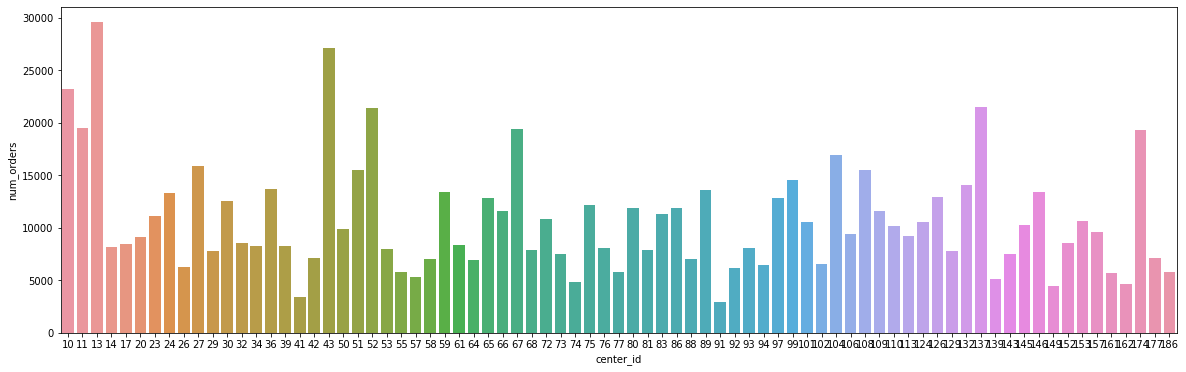

In [35]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(x='center_id', y='num_orders', data=sales_per_center_per_week, ax=ax)

Из 77 центров продаж есть центры, в которых достаточно большие недельные продажи (например, center_id = 10,13,43 и пр.) и есть центры с маленькими продажами (например, center_id = 41, 91,92 и др.)

## Генерация новых признаков

Т.к. нужно предсказать количество заказов за неделю для пары (центр;блюдо), то посчитаем дополнительные статистики для этой пары:  
1. Средние продажи определенного блюда в конкретном центре (скользящее среднее за 4 недели)
2. Медианные продажи определенного блюда в конкретном центре (скользящее среднее за 4 недели)
3. Сумма продаж определенного блюда в конкретном центре (скользящее среднее за 4 недели)
4. Отношение прошлой цены к будущей — возможно, со скидкой блюдо начнуть покупать активнее
5. Отношение базовой цены к цене продажи
6. Продажи за предыдущую неделю

In [36]:
def generate_features(input_df):
    df = input_df.copy()
    
    #создадим столбцы новых признаков в датасете
    df['rolling_mean_4w'] = 0
    df['rolling_median_4w'] = 0
    df['rolling_sum_4w'] = 0
    df['past_base_price_vs_current_base_price'] = 0
    df['past_checkout_price_vs_current_checkout_price'] = 0
    df['num_orders_past_week'] = 0
    df['base_price_vs_checkout_price'] = 0
    
    # создадим двухуровневый индекс из комбинаций всех значений в двух категориальных столбцах
    index = pd.MultiIndex.from_frame(df.loc[:, ['center_id', 'meal_id']].drop_duplicates())

    for i1, i2 in index.to_flat_index().values:
        # выбираем все значения для конкретного сочетания центра и блюда 
        subset = df.loc[(df['center_id'] == i1) & (df['meal_id'] == i2), 
                                ['week', 'base_price', 'checkout_price', 'num_orders']]
        new_subset = subset.loc[:, ['base_price', 'checkout_price', 'num_orders']]
        new_subset.index = subset['week']
        # создаем индекс, в котором будут присутствовать все недели, начиная с первой.
        # Если в какую-то неделю не было продаж данного блюда, в строках будут nan
        new_subset = new_subset.reindex(np.arange(1, new_subset.index[-1]+1)).fillna(0)
        new_subset['rolling_mean_4w'] = new_subset['num_orders'].rolling(window=4, min_periods=1).mean()
        new_subset['rolling_median_4w'] = new_subset['num_orders'].rolling(window=4, min_periods=1).median()
        new_subset['rolling_sum_4w'] = new_subset['num_orders'].rolling(window=4, min_periods=1).sum()
        # отношение base_price на прошлой неделе к base_price на текущей неделе
        new_subset['past_base_price_vs_current_base_price'] = \
            new_subset['base_price'].shift(1, fill_value=0)/(new_subset['base_price'] + 0.01) # добавим 1 копейку к цене, чтобы избежать деления на 0
        # отношение checkout_price на прошлой неделе к checkout_price на текущей неделе
        new_subset['past_checkout_price_vs_current_checkout_price'] = \
            new_subset['checkout_price'].shift(1, fill_value=0)/(new_subset['checkout_price'] + 0.01)
        # количество заказов на прошлой неделе
        new_subset['num_orders_past_week'] = new_subset['num_orders'].shift(1, fill_value=0)
        new_subset['base_price_vs_checkout_price'] = new_subset['base_price']/(new_subset['checkout_price'] + 0.01)

        # добавляем рассчитанные признаки в датасет
        df.loc[(df['center_id'] == i1) & (df['meal_id'] == i2),
                      ['week', 'num_orders', 'rolling_mean_4w', 'rolling_median_4w', 'rolling_sum_4w',
                      'past_base_price_vs_current_base_price', 'past_checkout_price_vs_current_checkout_price',
                      'num_orders_past_week', 'base_price_vs_checkout_price']] = subset.join(
            new_subset.loc[:, ['rolling_mean_4w', 'rolling_median_4w', 'rolling_sum_4w',
                              'past_base_price_vs_current_base_price', 'past_checkout_price_vs_current_checkout_price',
                              'num_orders_past_week', 'base_price_vs_checkout_price']], on='week')
        df.loc[:, ['rolling_mean_4w', 'rolling_median_4w', 'rolling_sum_4w']] = \
        df.loc[:, ['rolling_mean_4w', 'rolling_median_4w', 'rolling_sum_4w']].shift(1).fillna(0)
        
    return df

In [37]:
%%time
train_df = generate_features(train_data)

Wall time: 6min 25s


## Модель

### Решение без ML

Прогноз на следующую неделю - это продажи блюда за предыдущую неделю

In [38]:
#посчитаем метрику такого решения
print(mean_absolute_error(train_df['num_orders'], train_df['num_orders_past_week']))

118.3170465790695


### ML решение

Первой попробовала линейную регрессию. Для этого были нормализованны количественные признаки, посчитана матрица корреляций и удалены скоррелированные признаки. Признаки center_id, meal_id в модели не учитывались.  
Результат оказался не очень хорошим: MAE = 188

В дальнейшим решено использовать catboost, он т.к. работает быстро, умеет работать с категориальными признаками (не нужно дополнительно делать one-hot-encoder) 


In [39]:
#список количественных признаков
quantitative_features = ['base_price', 'checkout_price', 'rolling_mean_4w', 'rolling_median_4w', 'rolling_sum_4w', 
                        'past_base_price_vs_current_base_price', 'past_checkout_price_vs_current_checkout_price', 
                        'num_orders_past_week', 'base_price_vs_checkout_price', 'week']
#список категориальных признаков
category_features = ['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']
#список всех признаков
feature_cols = quantitative_features+category_features

In [40]:
#разделим выборку на train и test
X_train = train_df.loc[train_df['week'] <=100, feature_cols]
y_train = train_df.loc[train_df['week'] <=100, 'num_orders']

X_test = train_df.loc[train_df['week'] >100, feature_cols]
y_test = train_df.loc[train_df['week'] >100, 'num_orders']


In [41]:
X_train.head()

,base_price,checkout_price,rolling_mean_4w,rolling_median_4w,rolling_sum_4w,past_base_price_vs_current_base_price,past_checkout_price_vs_current_checkout_price,num_orders_past_week,base_price_vs_checkout_price,week,center_id,meal_id,emailer_for_promotion,homepage_featured
0,152.29,136.83,0.0,0.0,0.0,0.0,0.0,0.0,1.112906,1,55,1885,0,0
1,135.83,136.83,0.0,0.0,0.0,0.0,0.0,0.0,0.992619,1,55,1993,0,0
2,135.86,134.86,0.0,0.0,0.0,0.0,0.0,0.0,1.007340,1,55,2539,0,0
3,437.53,339.50,0.0,0.0,0.0,0.0,0.0,0.0,1.288710,1,55,2139,0,0
4,242.50,243.50,0.0,0.0,0.0,0.0,0.0,0.0,0.995852,1,55,2631,0,0


In [42]:
# Базовая модель: CatBoostRegressor с параметрами по умолчанию
from catboost import CatBoostRegressor
model = CatBoostRegressor(loss_function = 'MAE', random_state=42)

In [43]:
model.fit(X_train, y_train, cat_features=category_features, eval_set=(X_test, y_test), use_best_model=True, plot=True)
predictions = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 260.7552065	test: 256.8420202	best: 256.8420202 (0)	total: 380ms	remaining: 6m 19s
1:	learn: 254.4795321	test: 250.4516262	best: 250.4516262 (1)	total: 655ms	remaining: 5m 27s
2:	learn: 249.3713758	test: 245.2850045	best: 245.2850045 (2)	total: 966ms	remaining: 5m 21s
3:	learn: 245.3531892	test: 241.4337148	best: 241.4337148 (3)	total: 1.24s	remaining: 5m 8s
4:	learn: 240.8305674	test: 236.6843908	best: 236.6843908 (4)	total: 1.5s	remaining: 4m 58s
5:	learn: 237.6498273	test: 233.5267524	best: 233.5267524 (5)	total: 1.77s	remaining: 4m 54s
6:	learn: 232.9403726	test: 228.6857739	best: 228.6857739 (6)	total: 2.03s	remaining: 4m 48s
7:	learn: 228.7217379	test: 224.3757306	best: 224.3757306 (7)	total: 2.3s	remaining: 4m 45s
8:	learn: 223.9058137	test: 219.5259542	best: 219.5259542 (8)	total: 2.61s	remaining: 4m 47s
9:	learn: 219.4126475	test: 215.1051327	best: 215.1051327 (9)	total: 2.9s	remaining: 4m 47s
10:	learn: 215.3162964	test: 211.0124139	best: 211.0124139 (10)	total: 3.2

88:	learn: 97.7914913	test: 93.8124189	best: 93.8124189 (88)	total: 20.5s	remaining: 3m 29s
89:	learn: 97.4519276	test: 93.4302112	best: 93.4302112 (89)	total: 20.7s	remaining: 3m 29s
90:	learn: 97.1300437	test: 93.0799863	best: 93.0799863 (90)	total: 21s	remaining: 3m 29s
91:	learn: 96.8027145	test: 92.7553402	best: 92.7553402 (91)	total: 21.2s	remaining: 3m 29s
92:	learn: 96.4484192	test: 92.3864701	best: 92.3864701 (92)	total: 21.4s	remaining: 3m 29s
93:	learn: 96.2049098	test: 92.1698254	best: 92.1698254 (93)	total: 21.6s	remaining: 3m 28s
94:	learn: 95.9221466	test: 91.8381857	best: 91.8381857 (94)	total: 21.9s	remaining: 3m 28s
95:	learn: 95.7066391	test: 91.6388502	best: 91.6388502 (95)	total: 22.1s	remaining: 3m 27s
96:	learn: 95.3626599	test: 91.3093870	best: 91.3093870 (96)	total: 22.4s	remaining: 3m 28s
97:	learn: 95.0424393	test: 90.9785792	best: 90.9785792 (97)	total: 22.6s	remaining: 3m 27s
98:	learn: 94.7432336	test: 90.7028697	best: 90.7028697 (98)	total: 22.8s	remainin

176:	learn: 84.5936354	test: 83.7959968	best: 82.7232120 (158)	total: 39.6s	remaining: 3m 3s
177:	learn: 84.5577811	test: 83.7897795	best: 82.7232120 (158)	total: 39.8s	remaining: 3m 3s
178:	learn: 84.5222283	test: 84.4394763	best: 82.7232120 (158)	total: 40s	remaining: 3m 3s
179:	learn: 84.4300164	test: 84.4078865	best: 82.7232120 (158)	total: 40.3s	remaining: 3m 3s
180:	learn: 84.4025250	test: 84.3940131	best: 82.7232120 (158)	total: 40.5s	remaining: 3m 3s
181:	learn: 84.3789553	test: 84.3829998	best: 82.7232120 (158)	total: 40.7s	remaining: 3m 2s
182:	learn: 84.3245853	test: 84.3434128	best: 82.7232120 (158)	total: 40.9s	remaining: 3m 2s
183:	learn: 84.3017672	test: 84.5080574	best: 82.7232120 (158)	total: 41.1s	remaining: 3m 2s
184:	learn: 84.2746618	test: 84.4805076	best: 82.7232120 (158)	total: 41.3s	remaining: 3m 1s
185:	learn: 84.2191176	test: 84.4600316	best: 82.7232120 (158)	total: 41.5s	remaining: 3m 1s
186:	learn: 84.1511453	test: 84.4392503	best: 82.7232120 (158)	total: 41

265:	learn: 81.8734955	test: 85.5982439	best: 82.7232120 (158)	total: 59.7s	remaining: 2m 44s
266:	learn: 81.8320663	test: 85.5473676	best: 82.7232120 (158)	total: 60s	remaining: 2m 44s
267:	learn: 81.8096245	test: 85.5347500	best: 82.7232120 (158)	total: 1m	remaining: 2m 44s
268:	learn: 81.7753946	test: 85.5005825	best: 82.7232120 (158)	total: 1m	remaining: 2m 44s
269:	learn: 81.7626966	test: 85.6669042	best: 82.7232120 (158)	total: 1m	remaining: 2m 44s
270:	learn: 81.7500346	test: 85.7891432	best: 82.7232120 (158)	total: 1m 1s	remaining: 2m 44s
271:	learn: 81.7031078	test: 85.7656508	best: 82.7232120 (158)	total: 1m 1s	remaining: 2m 43s
272:	learn: 81.6904383	test: 85.7627738	best: 82.7232120 (158)	total: 1m 1s	remaining: 2m 43s
273:	learn: 81.6622207	test: 85.7407216	best: 82.7232120 (158)	total: 1m 1s	remaining: 2m 43s
274:	learn: 81.6524116	test: 85.7314673	best: 82.7232120 (158)	total: 1m 1s	remaining: 2m 42s
275:	learn: 81.6406042	test: 85.7307965	best: 82.7232120 (158)	total: 1

352:	learn: 79.9997393	test: 87.2075120	best: 82.7232120 (158)	total: 1m 22s	remaining: 2m 30s
353:	learn: 79.9979117	test: 87.2082482	best: 82.7232120 (158)	total: 1m 22s	remaining: 2m 30s
354:	learn: 79.9766044	test: 87.2049365	best: 82.7232120 (158)	total: 1m 22s	remaining: 2m 30s
355:	learn: 79.9730800	test: 87.2059040	best: 82.7232120 (158)	total: 1m 22s	remaining: 2m 29s
356:	learn: 79.9660097	test: 87.4282609	best: 82.7232120 (158)	total: 1m 23s	remaining: 2m 29s
357:	learn: 79.9481945	test: 87.4019836	best: 82.7232120 (158)	total: 1m 23s	remaining: 2m 29s
358:	learn: 79.9390401	test: 87.3973637	best: 82.7232120 (158)	total: 1m 23s	remaining: 2m 29s
359:	learn: 79.9160013	test: 87.3915607	best: 82.7232120 (158)	total: 1m 23s	remaining: 2m 29s
360:	learn: 79.9079736	test: 87.3863679	best: 82.7232120 (158)	total: 1m 24s	remaining: 2m 29s
361:	learn: 79.8992486	test: 87.3810937	best: 82.7232120 (158)	total: 1m 24s	remaining: 2m 28s
362:	learn: 79.8965498	test: 87.3720684	best: 82.7

439:	learn: 78.3744040	test: 88.4087679	best: 82.7232120 (158)	total: 1m 45s	remaining: 2m 14s
440:	learn: 78.3686766	test: 88.4131770	best: 82.7232120 (158)	total: 1m 45s	remaining: 2m 13s
441:	learn: 78.3139671	test: 88.3692190	best: 82.7232120 (158)	total: 1m 45s	remaining: 2m 13s
442:	learn: 78.3050013	test: 88.3788699	best: 82.7232120 (158)	total: 1m 46s	remaining: 2m 13s
443:	learn: 78.2870731	test: 88.3682560	best: 82.7232120 (158)	total: 1m 46s	remaining: 2m 13s
444:	learn: 78.2524337	test: 88.3565190	best: 82.7232120 (158)	total: 1m 46s	remaining: 2m 13s
445:	learn: 78.2254521	test: 88.3510996	best: 82.7232120 (158)	total: 1m 47s	remaining: 2m 13s
446:	learn: 78.2120152	test: 88.4966373	best: 82.7232120 (158)	total: 1m 47s	remaining: 2m 12s
447:	learn: 78.2070198	test: 88.4953932	best: 82.7232120 (158)	total: 1m 47s	remaining: 2m 12s
448:	learn: 78.2048667	test: 88.4953558	best: 82.7232120 (158)	total: 1m 47s	remaining: 2m 12s
449:	learn: 78.1838579	test: 88.4805138	best: 82.7

527:	learn: 77.0884381	test: 89.2642604	best: 82.7232120 (158)	total: 2m 10s	remaining: 1m 56s
528:	learn: 77.0845484	test: 89.2863595	best: 82.7232120 (158)	total: 2m 11s	remaining: 1m 56s
529:	learn: 77.0801229	test: 89.2916576	best: 82.7232120 (158)	total: 2m 11s	remaining: 1m 56s
530:	learn: 77.0656900	test: 89.2843773	best: 82.7232120 (158)	total: 2m 11s	remaining: 1m 56s
531:	learn: 77.0245094	test: 89.2542126	best: 82.7232120 (158)	total: 2m 11s	remaining: 1m 56s
532:	learn: 77.0184257	test: 89.2502419	best: 82.7232120 (158)	total: 2m 12s	remaining: 1m 55s
533:	learn: 77.0099326	test: 89.2422507	best: 82.7232120 (158)	total: 2m 12s	remaining: 1m 55s
534:	learn: 77.0039554	test: 89.2379296	best: 82.7232120 (158)	total: 2m 12s	remaining: 1m 55s
535:	learn: 76.9967569	test: 89.2270463	best: 82.7232120 (158)	total: 2m 13s	remaining: 1m 55s
536:	learn: 76.9708151	test: 89.2410924	best: 82.7232120 (158)	total: 2m 13s	remaining: 1m 55s
537:	learn: 76.9512648	test: 89.2349734	best: 82.7

614:	learn: 76.0231120	test: 89.4863501	best: 82.7232120 (158)	total: 2m 35s	remaining: 1m 37s
615:	learn: 76.0135229	test: 89.4800755	best: 82.7232120 (158)	total: 2m 35s	remaining: 1m 37s
616:	learn: 76.0069705	test: 89.4793193	best: 82.7232120 (158)	total: 2m 35s	remaining: 1m 36s
617:	learn: 75.9776395	test: 89.4644440	best: 82.7232120 (158)	total: 2m 36s	remaining: 1m 36s
618:	learn: 75.9716965	test: 89.4613462	best: 82.7232120 (158)	total: 2m 36s	remaining: 1m 36s
619:	learn: 75.9681980	test: 89.4510650	best: 82.7232120 (158)	total: 2m 36s	remaining: 1m 36s
620:	learn: 75.9474720	test: 89.4303002	best: 82.7232120 (158)	total: 2m 37s	remaining: 1m 35s
621:	learn: 75.9437880	test: 89.4221322	best: 82.7232120 (158)	total: 2m 37s	remaining: 1m 35s
622:	learn: 75.9378717	test: 89.4165299	best: 82.7232120 (158)	total: 2m 37s	remaining: 1m 35s
623:	learn: 75.9327302	test: 89.4205780	best: 82.7232120 (158)	total: 2m 37s	remaining: 1m 35s
624:	learn: 75.9217223	test: 89.4170244	best: 82.7

701:	learn: 75.2875712	test: 90.2479974	best: 82.7232120 (158)	total: 2m 59s	remaining: 1m 16s
702:	learn: 75.2837409	test: 90.2457673	best: 82.7232120 (158)	total: 3m	remaining: 1m 16s
703:	learn: 75.2557079	test: 90.2335500	best: 82.7232120 (158)	total: 3m	remaining: 1m 15s
704:	learn: 75.2515811	test: 90.2416402	best: 82.7232120 (158)	total: 3m	remaining: 1m 15s
705:	learn: 75.2497521	test: 90.2374024	best: 82.7232120 (158)	total: 3m	remaining: 1m 15s
706:	learn: 75.2457538	test: 90.2325004	best: 82.7232120 (158)	total: 3m 1s	remaining: 1m 15s
707:	learn: 75.2401178	test: 90.2299130	best: 82.7232120 (158)	total: 3m 1s	remaining: 1m 14s
708:	learn: 75.2385381	test: 90.2311040	best: 82.7232120 (158)	total: 3m 1s	remaining: 1m 14s
709:	learn: 75.2362730	test: 90.2329985	best: 82.7232120 (158)	total: 3m 1s	remaining: 1m 14s
710:	learn: 75.2103348	test: 90.2185183	best: 82.7232120 (158)	total: 3m 2s	remaining: 1m 14s
711:	learn: 75.1999019	test: 90.2222086	best: 82.7232120 (158)	total: 3

789:	learn: 74.5740204	test: 90.5117991	best: 82.7232120 (158)	total: 3m 24s	remaining: 54.4s
790:	learn: 74.5649543	test: 90.5162383	best: 82.7232120 (158)	total: 3m 24s	remaining: 54.2s
791:	learn: 74.5610264	test: 90.5122073	best: 82.7232120 (158)	total: 3m 25s	remaining: 53.9s
792:	learn: 74.5481733	test: 90.5127732	best: 82.7232120 (158)	total: 3m 25s	remaining: 53.6s
793:	learn: 74.5360518	test: 90.5149301	best: 82.7232120 (158)	total: 3m 25s	remaining: 53.4s
794:	learn: 74.5248318	test: 90.5123977	best: 82.7232120 (158)	total: 3m 26s	remaining: 53.1s
795:	learn: 74.5111217	test: 90.5105775	best: 82.7232120 (158)	total: 3m 26s	remaining: 52.9s
796:	learn: 74.5073054	test: 90.5059736	best: 82.7232120 (158)	total: 3m 26s	remaining: 52.6s
797:	learn: 74.4995943	test: 90.8919817	best: 82.7232120 (158)	total: 3m 26s	remaining: 52.4s
798:	learn: 74.4771933	test: 90.8742216	best: 82.7232120 (158)	total: 3m 27s	remaining: 52.1s
799:	learn: 74.4742701	test: 90.8767232	best: 82.7232120 (15

877:	learn: 73.9509806	test: 91.4504168	best: 82.7232120 (158)	total: 3m 49s	remaining: 31.9s
878:	learn: 73.9482878	test: 91.4544387	best: 82.7232120 (158)	total: 3m 49s	remaining: 31.7s
879:	learn: 73.9447941	test: 91.4555368	best: 82.7232120 (158)	total: 3m 50s	remaining: 31.4s
880:	learn: 73.9358735	test: 91.4563052	best: 82.7232120 (158)	total: 3m 50s	remaining: 31.1s
881:	learn: 73.9337569	test: 91.4499799	best: 82.7232120 (158)	total: 3m 50s	remaining: 30.9s
882:	learn: 73.9246733	test: 91.6458907	best: 82.7232120 (158)	total: 3m 51s	remaining: 30.6s
883:	learn: 73.9142830	test: 91.7358077	best: 82.7232120 (158)	total: 3m 51s	remaining: 30.4s
884:	learn: 73.9088571	test: 91.7385694	best: 82.7232120 (158)	total: 3m 51s	remaining: 30.1s
885:	learn: 73.8899107	test: 91.7449776	best: 82.7232120 (158)	total: 3m 52s	remaining: 29.9s
886:	learn: 73.8878265	test: 91.7559856	best: 82.7232120 (158)	total: 3m 52s	remaining: 29.6s
887:	learn: 73.8818290	test: 91.7517753	best: 82.7232120 (15

965:	learn: 73.4389750	test: 92.5996475	best: 82.7232120 (158)	total: 4m 15s	remaining: 8.98s
966:	learn: 73.4375934	test: 92.5982217	best: 82.7232120 (158)	total: 4m 15s	remaining: 8.72s
967:	learn: 73.4328999	test: 92.6916124	best: 82.7232120 (158)	total: 4m 15s	remaining: 8.46s
968:	learn: 73.4309563	test: 92.6915124	best: 82.7232120 (158)	total: 4m 16s	remaining: 8.19s
969:	learn: 73.4191311	test: 92.6876858	best: 82.7232120 (158)	total: 4m 16s	remaining: 7.93s
970:	learn: 73.4176966	test: 92.6924813	best: 82.7232120 (158)	total: 4m 16s	remaining: 7.67s
971:	learn: 73.4160123	test: 92.6916986	best: 82.7232120 (158)	total: 4m 17s	remaining: 7.4s
972:	learn: 73.4123261	test: 92.6867038	best: 82.7232120 (158)	total: 4m 17s	remaining: 7.14s
973:	learn: 73.4106396	test: 92.6830177	best: 82.7232120 (158)	total: 4m 17s	remaining: 6.88s
974:	learn: 73.4082682	test: 92.6813305	best: 82.7232120 (158)	total: 4m 17s	remaining: 6.61s
975:	learn: 73.4058265	test: 92.6798931	best: 82.7232120 (158

In [44]:
for fn, fi in zip(model.feature_names_, model.feature_importances_):
    print(f'{fn}: {round(fi, 3)}')

base_price: 1.348
checkout_price: 2.623
rolling_mean_4w: 0.002
rolling_median_4w: 0.002
rolling_sum_4w: 0.01
past_base_price_vs_current_base_price: 0.178
past_checkout_price_vs_current_checkout_price: 11.556
num_orders_past_week: 46.945
base_price_vs_checkout_price: 2.557
week: 0.415
center_id: 8.163
meal_id: 10.389
emailer_for_promotion: 8.418
homepage_featured: 7.392


In [45]:
#загружаем тестовые данные
test_data = pd.read_csv('./Data/test_df.csv')

In [46]:
test_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1197045,131,55,1885,149.44,149.44,0,0
1,1339072,131,55,1993,150.41,148.41,0,0
2,1270238,131,55,2539,150.38,151.38,0,0
3,1392407,131,55,2139,321.13,319.13,0,0
4,1447505,131,55,2631,163.93,165.93,0,0


In [47]:
# соединяем данные train и test в одну таблицу для дальнейшего прогноза
full_data = pd.concat([train_data, test_data], axis=0, sort=False)

In [48]:
#строим прогноз на test
for w in range(test_data['week'].min(), test_data['week'].max()+1):
    new_week_features = generate_features(full_data.loc[(full_data['week'] >= w-10) & (full_data['week'] <= w)])
    new_week_predictions = model.predict(new_week_features.loc[new_week_features['week'] == w, feature_cols])
    full_data.loc[full_data['week'] == w, 'num_orders'] = new_week_predictions

In [65]:
full_data['num_orders'] = full_data['num_orders'].round(0).astype(int)

In [71]:
test_data_predict = full_data.loc[full_data['week'] >=131, ['id', 'num_orders']]

In [72]:
test_data_predict.to_csv('test_predictions.csv', index=False)